#Right click to open this notebook in Colab:

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/mettinger/mixModel/blob/main/mixModelTest.ipynb)

# The statistical model (instantiated parameters are listed in cell below):

$mode_i \sim$ Normal(modeMean, modeCovariance) for $i = 1,...,$nModesPerPerson    

$location_{ij} \sim$ Normal($mode_i$, personCovariance) for $i = 1,...,$nModesPerPerson and $j = 1,...,$nPerson 

$data_{ijk} \sim $ Normal($location_{ij}$, dataCovariance) for $i = 1,...,$nModesPerPerson and $j = 1,...,$nPerson and $k = 1,...,$nSamplesPerLocationPerPerson


# Install Pyro and do imports.

In [1]:
!pip3 install pyro-ppl 

     |████████████████████████████████| 614kB 5.8MB/s 


In [2]:
%matplotlib inline

import pyro
import pyro.distributions as dist
from pyro import poutine
from pyro.infer.autoguide import AutoGuideList, AutoDelta, AutoDiagonalNormal, AutoMultivariateNormal, AutoDiscreteParallel 
from pyro.infer.autoguide import init_to_mean, init_to_uniform
from pyro.optim import Adam
from pyro.infer import SVI, Trace_ELBO, TraceEnum_ELBO, config_enumerate, infer_discrete
from pyro.infer.mcmc.api import MCMC
from pyro.infer.mcmc import NUTS

from torch.distributions import constraints
import torch
import numpy as np
from matplotlib import pyplot
import pandas as pd


# Instantiate parameters

In [3]:
nPerson = 2
nModesPerPerson = 3
nSpectralCoeff = 2 # i.e. the dimensionality of the samples
nSamplesPerLocationPerPerson = 4

# scaling factors for diagonal covariance matrices
modeCovarianceFactor = 100
personCovarianceFactor = 1
dataCovarianceFactor = .01

modeMean = torch.zeros(nSpectralCoeff)
modeCovariance = modeCovarianceFactor * torch.eye(nSpectralCoeff)
personCovariance = personCovarianceFactor * torch.eye(nSpectralCoeff)
dataCovariance = dataCovarianceFactor * torch.eye(nSpectralCoeff)

# Function for generating data

In [4]:
def generateData(nPerson, nModesPerPerson, nSpectralCoeff, nSamplesPerLocationPerPerson):
    modeLocs = {}
    locs = {}
    data = []
    personIndex = []
    
    for thisMode in pyro.plate("modeLoc_loop", nModesPerPerson):
        modeLocName = "modeLoc_" + str(thisMode)
        thisModeLoc = pyro.sample(modeLocName, dist.MultivariateNormal(modeMean, modeCovariance))
        modeLocs[modeLocName] = thisModeLoc
        
        for thisPerson in pyro.plate("person_loop", nPerson):
            locName = "locModePerson_" + str(thisMode) + "_" + str(thisPerson)
            thisLoc = pyro.sample(locName, dist.MultivariateNormal(thisModeLoc, personCovariance))
            locs[locName] = thisLoc

            for thisDataSample in pyro.plate("data_loop", nSamplesPerLocationPerPerson):
                dataName = "dataMPS_" + str(thisMode) + "_" + str(thisPerson) + "_" + str(thisDataSample)
                thisDatum = pyro.sample(dataName, dist.MultivariateNormal(thisLoc, dataCovariance)).numpy()
                data.append(thisDatum)
                personIndex.append(thisPerson)
    
    return modeLocs, locs, np.hstack((np.expand_dims(np.array(personIndex).transpose(),1), np.array(data)))

# Generate simulated data

In [5]:
#pyro.set_rng_seed(1)
pyro.clear_param_store()
modeLocsTrue, locsTrue, data = generateData(nPerson, nModesPerPerson, nSpectralCoeff, nSamplesPerLocationPerPerson)

# Print the paramters and plot the simulated data

{'modeLoc_0': tensor([  9.6220, -17.7215]), 'modeLoc_1': tensor([-14.8312,  -9.7598]), 'modeLoc_2': tensor([  9.2372, -10.8825])}

{'locModePerson_0_0': tensor([ 11.8371, -19.1269]), 'locModePerson_0_1': tensor([  9.5038, -18.2407]), 'locModePerson_1_0': tensor([-12.1012, -10.7619]), 'locModePerson_1_1': tensor([-15.5756,  -8.6256]), 'locModePerson_2_0': tensor([  8.1690, -11.0237]), 'locModePerson_2_1': tensor([ 7.4998, -9.2040])}


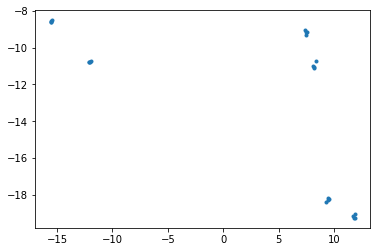

In [6]:
person = torch.tensor(np.cast['int'](data[:,0]))
samples = torch.tensor(data[:,1:]).float()
print(modeLocsTrue)
print()
print(locsTrue)

pyplot.figure()
pyplot.plot(data[:,1], data[:,2],'.')

# Define the model and guide

In [7]:
@config_enumerate
def model(person, sample):
    
    loc = torch.zeros(size=(nModesPerPerson, nPerson, nSpectralCoeff))
    
    for thisMode in range(nModesPerPerson):
        modeLocName = "modeLoc_" + str(thisMode)
        thisModeLoc = pyro.sample(modeLocName, dist.MultivariateNormal(modeMean, modeCovariance))
        
        for thisPerson in range(nPerson):
            locName = "locModePerson_" + str(thisMode) + "_" + str(thisPerson)
            thisLoc = pyro.sample(locName, dist.MultivariateNormal(thisModeLoc, personCovariance))

            loc[thisMode, thisPerson, :] = thisLoc.clone()
    
    with pyro.plate('data_loop', len(person)):
        modeAssignment = pyro.sample('modeAssignment', 
                                     dist.Categorical((1./nModesPerPerson) * torch.ones(nModesPerPerson)))
        
        pyro.sample('obs', 
                    dist.MultivariateNormal(loc[modeAssignment, person, :], dataCovariance), 
                    obs=sample)
    
def guide(person, sample):

        modeLocMean = [0 for i in range(nModesPerPerson)]
        locModePersonMean = [[0 for i in range(nPerson)] for j in range(nModesPerPerson)]
        allSamples = {}

        for thisMode in range(nModesPerPerson):
            
            modeLocName = "modeLoc_" + str(thisMode)
            
            modeLocMean[thisMode] = pyro.param('a{}'.format(thisMode), modeLocsTrue[modeLocName].clone())
            allSamples[modeLocName] = pyro.sample(modeLocName, dist.MultivariateNormal(modeLocMean[thisMode], modeCovariance))
        
            for thisPerson in range(nPerson):
                
                locName = "locModePerson_" + str(thisMode) + "_" + str(thisPerson)
                locModePersonMean[thisMode][thisPerson] = pyro.param('b{}{}'.format(thisMode,thisPerson), locsTrue[locName].clone())
                
                allSamples[locName] = pyro.sample(locName, dist.MultivariateNormal(locModePersonMean[thisMode][thisPerson], personCovariance))

        modeAssignment = pyro.sample("modeAssignment", 
                                     dist.Categorical((1./nModesPerPerson) * torch.ones(nModesPerPerson)))

# Do SVI

In [8]:
pyro.clear_param_store()

optim = pyro.optim.Adam({'lr': 0.05})
elbo = TraceEnum_ELBO()
svi = SVI(model, guide, optim, loss=elbo)

num_iters = 5000 
losses = []

for i in range(num_iters):
    loss = svi.step(person, samples)
    losses.append(loss)
    if i % 500 == 0:
        print("Elbo loss: {}".format(loss))

Elbo loss: 267176.40625
Elbo loss: 183812.390625
Elbo loss: 174858.5625
Elbo loss: 186146.21875
Elbo loss: 182307.5
Elbo loss: 170267.109375
Elbo loss: 183102.6875
Elbo loss: 176627.90625
Elbo loss: 184413.6875
Elbo loss: 182102.90625


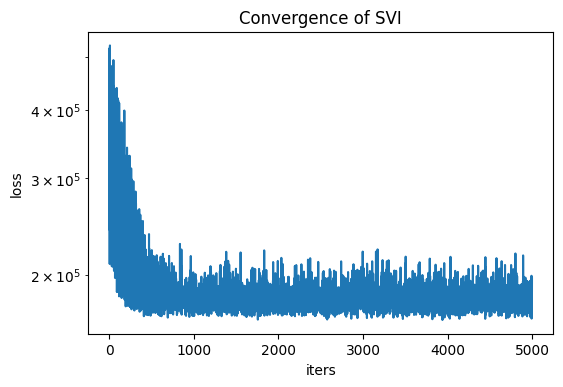

In [9]:
pyplot.figure(dpi=100).set_facecolor('white')
pyplot.plot(losses)
pyplot.xlabel('iters')
pyplot.ylabel('loss')
pyplot.yscale('log')
pyplot.title('Convergence of SVI');

# Are the parameter estimates close to the ground truth?

In [10]:
print(modeLocsTrue)
print()
print(locsTrue)

{'modeLoc_0': tensor([  9.6220, -17.7215]), 'modeLoc_1': tensor([-14.8312,  -9.7598]), 'modeLoc_2': tensor([  9.2372, -10.8825])}

{'locModePerson_0_0': tensor([ 11.8371, -19.1269]), 'locModePerson_0_1': tensor([  9.5038, -18.2407]), 'locModePerson_1_0': tensor([-12.1012, -10.7619]), 'locModePerson_1_1': tensor([-15.5756,  -8.6256]), 'locModePerson_2_0': tensor([  8.1690, -11.0237]), 'locModePerson_2_1': tensor([ 7.4998, -9.2040])}


In [11]:
list(pyro.get_param_store().items())

[('a0', tensor([  1.0778, -13.0914], requires_grad=True)),
 ('b00', tensor([  2.7967, -13.5060], requires_grad=True)),
 ('b01', tensor([  0.6224, -11.7839], requires_grad=True)),
 ('a1', tensor([  2.1527, -12.4237], requires_grad=True)),
 ('b10', tensor([  2.7810, -13.6077], requires_grad=True)),
 ('b11', tensor([  0.5288, -12.3640], requires_grad=True)),
 ('a2', tensor([  0.8032, -13.5890], requires_grad=True)),
 ('b20', tensor([  2.8073, -13.2735], requires_grad=True)),
 ('b21', tensor([  0.7946, -12.0200], requires_grad=True))]